In [1]:
!pip install -q transformers

In [2]:
!pip install -q datasets jiwer

In [3]:
!pip install accelerate -U

In [4]:
!pip install git+https://github.com/huggingface/huggingface_hub
!pip install wandb -qU
!pip install ipywidgets

  Cloning https://github.com/huggingface/huggingface_hub to /tmp/pip-req-build-27wf2vtr
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/huggingface_hub /tmp/pip-req-build-27wf2vtr
  Resolved https://github.com/huggingface/huggingface_hub to commit 5ff2d150d121d04799b78bc08f2343c21b8f07a9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for huggingface_hub: filename=huggingface_hub-0.23.0.dev0-py3-none-any.whl size=401600 sha256=c909068006c08092d55a0d3a01d55ba9da1d8cff1c0ae76116218b72967767b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-nwf5pmrt/wheels/81/77/10/4ea0848421de7e11b030d8127ca1139b1e0e254f714938175f
Successfully built huggingface_hub
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.23.0
    Uninstalling huggingface-hub-0.23.0:
      Successfully uninstalled huggingface-hub-0.23.0


In [6]:
import wandb
wandb.login()

wandb: Currently logged in as: ta4tsering (monlamai). Use `wandb login --relogin` to force relogin


True

In [7]:
from datasets import load_dataset

lhasa_dataset = load_dataset('ta4tsering/Lhasa_kanjur_transcription_datasets')
train_df = lhasa_dataset['train']
eval_df = lhasa_dataset['eval']

We split up the data into training + testing, using sklearn's `train_test_split` function.

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`).

In [8]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class TibetanDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=171):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['filename'][idx]
        text = self.df['label'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length,truncation=True).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [9]:
encode, decode = "google/vit-base-patch16-224-in21k", "sangjeedondrub/tibetan-roberta-base"

Let's initialize the training and evaluation datasets:

In [10]:
from transformers import TrOCRProcessor, ViTImageProcessor, RobertaTokenizer

feature_extractor=ViTImageProcessor.from_pretrained(encode)
tokenizer = RobertaTokenizer.from_pretrained(decode)
print(tokenizer.vocab_size)
processor = TrOCRProcessor(image_processor=feature_extractor, tokenizer=tokenizer)
train_dataset = TibetanDataset(root_dir='/TrOCR-Pipeline/trocr/tibetan-dataset/train/',
                           df=train_df,
                           processor=processor)
eval_dataset = TibetanDataset(root_dir='/TrOCR-Pipeline/trocr/tibetan-dataset/train/',
                           df=eval_df,
                           processor=processor)

22869


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 133024
Number of validation examples: 16640


Let's verify an example from the training dataset:

In [12]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 224, 224])
labels torch.Size([171])


We can also check the original image and decode the labels:

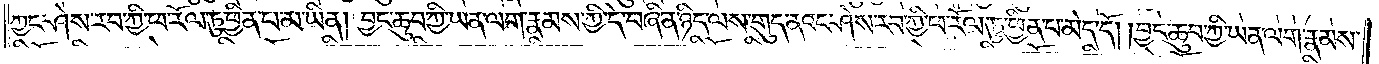

In [13]:
image = Image.open(train_dataset.root_dir + train_df['filename'][0]).convert("RGB")
image

In [14]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

ཀྱང་ཤེས་རབ་ཀྱི་ཕ་རོལ་ཏུ་ཕྱིན་པ་མ་ཡིན། བྱང་ཆུབ་ཀྱི་ཡན་ལག་རྣམས་ཀྱི་དེ་བཞིན་ཉིད་ལས་གུད་ནའང་ཤེས་རབ་ཀྱི་ཕ་རོལ་ཏུ་ཕྱིན་པ་མེད་དོ། །བྱང་ཆུབ་ཀྱི་ཡན་ལག་རྣམས་


## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [15]:
use_existing_model = False
date = None

In [16]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if use_existing_model:
    if date is not None:
        model = VisionEncoderDecoderModel.from_pretrained(f"best_model_{date}")
    else:
        model = VisionEncoderDecoderModel.from_pretrained("test")
else:
    model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encode, decode)

model.to(device)

assert model.config.decoder.is_decoder is True
assert model.config.decoder.add_cross_attention is True

cuda


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at sangjeedondrub/tibetan-roberta-base and are newly initialized: ['roberta.encoder.layer.0.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.0.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.0.crossattention.output.dense.bias', 'roberta.encoder.layer.0.crossattention.output.dense.weight', 'roberta.encoder.layer.0.crossattention.self.key.bias', 'roberta.encoder.layer.0.crossattention.self.key.weight', 'roberta.encoder.layer.0.crossattention.self.query.bias', 'roberta.encoder.layer.0.crossattention.self.query.weight', 'roberta.encoder.layer.0.crossattention.self.value.bias', 'roberta.encoder.layer.0.

In [17]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 170
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [18]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True, 
    output_dir="TrOCR-Tibetan",
    logging_steps=100,
    save_steps=4000,
    eval_steps=4000,
    report_to=["wandb"]
)

In [19]:
from datasets import load_metric

cer_metric = load_metric("cer")

/tmp/ipykernel_2354/152175726.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [20]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

Next, we can define some training hyperparameters by instantiating the `training_args`. Note that there are many more parameters, all of which can be found in the [documentation](https://huggingface.co/transformers/main_classes/trainer.html#seq2seqtrainingarguments). You can for example decide what the batch size is for training/evaluation, whether to use mixed precision training (lower memory), the frequency at which you want to save the model, etc.

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

The compute_metrics function takes an `EvalPrediction` (which is a NamedTuple) as input, and should return a dictionary. The model will return an EvalPrediction at evaluation, which consists of 2 things:
* predictions: the predictions by the model.
* label_ids: the actual ground-truth labels.

Let's train! We also provide the `default_data_collator` to the Trainer, which is used to batch together examples.

Note that evaluation takes quite a long time, as we're using beam search for decoding, which requires several forward passes for a given example.

In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss,Validation Loss,Cer
4000,1.109400,1.086114,0.774890
8000,1.014500,0.983288,0.770698
12000,0.987700,0.931799,0.778356
16000,0.946900,0.890540,0.771610
20000,0.867700,0.862012,0.768935
24000,0.852100,0.832159,0.759791
28000,0.838600,0.810343,0.760448
32000,0.797300,0.783022,0.748905
36000,0.754100,0.752466,0.739631
40000,0.717600,0.729105,0.734603


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1256: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 170, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (htt

## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.